In [ ]:
import os
import xml.etree.ElementTree as ET

# Pathes
data_root = 'VOC_dataset/VOCdevkit'
years = ['VOC2007', 'VOC2012']
output_dir = 'data/original_labels'
os.makedirs(output_dir, exist_ok=True)

# Class mapping
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
           'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
class_to_id = {cls: i for i, cls in enumerate(classes)}

for year in years:
    annotations_dir = os.path.join(data_root, year, 'Annotations')
    for xml_file in os.listdir(annotations_dir):
        if not xml_file.endswith('.xml'):
            continue
        xml_path = os.path.join(annotations_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        img_filename = root.find('filename').text
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)
        
        txt_lines = []
        for obj in root.iter('object'):
            cls_name = obj.find('name').text.lower()
            if cls_name not in class_to_id:
                continue
            cls_id = class_to_id[cls_name]
            
            bndbox = obj.find('bndbox')
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)
            
            # Normalization for YOLO
            x_center = (xmin + xmax) / 2 / width
            y_center = (ymin + ymax) / 2 / height
            w = (xmax - xmin) / width
            h = (ymax - ymin) / height
            
            txt_lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")
        
        # Saving TXT (with the same name as XML, but in output_dir)
        txt_path = os.path.join(output_dir, xml_file.replace('.xml', '.txt'))
        if txt_lines:
            with open(txt_path, 'w') as f:
                f.write('\n'.join(txt_lines)) 

print("Conversion completed! TXT в data/original_labels")

Конвертація завершена! TXT в data/labels


In [ ]:
import os
import shutil

def create_custom_splits_and_copy(years, base_dir, output_base='data/custom_data'):
    # Create folders for images and labels in custom_data
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_base, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(output_base, 'labels', split), exist_ok=True)
    
    # Dictionaries for splits (train based on trainval for more data)
    splits = {
        'train': 'trainval',
        'val': 'val',
        'test': 'test'
    }
    
    # Collect unique IDs for each split
    all_splits = {split: set() for split in splits}
    
    for year in years:
        imagesets_dir = os.path.join(base_dir, year, 'ImageSets/Main')
        jpeg_dir = os.path.join(base_dir, year, 'JPEGImages')
        
        for split, original_txt in splits.items():
            txt_path = os.path.join(imagesets_dir, f'{original_txt}.txt')
            if os.path.exists(txt_path):
                with open(txt_path, 'r') as f:
                    ids = [line.strip() for line in f if line.strip()]
                all_splits[split].update(ids)
    
    # Copy files with prefixes for uniqueness
    for split in all_splits:
        for img_id in all_splits[split]:
            for year in years:
                original_jpg = os.path.join(base_dir, year, 'JPEGImages', f'{img_id}.jpg')
                original_txt = os.path.join('data/original_labels', f'{img_id}.txt')
                
                if os.path.exists(original_jpg) and os.path.exists(original_txt):
                    new_id = f'{year}_{img_id}'  # Year prefix for uniqueness
                    new_jpg = os.path.join(output_base, 'images', split, f'{new_id}.jpg')
                    new_txt = os.path.join(output_base, 'labels', split, f'{new_id}.txt')
                    
                    shutil.copy(original_jpg, new_jpg)
                    shutil.copy(original_txt, new_txt)
                    break
    
    # Creating custom TXT with new IDs (for .yaml)
    for split in all_splits:
        custom_txt_path = os.path.join(output_base, f'custom_{split}.txt')
        with open(custom_txt_path, 'w') as f:
            for img_id in sorted(all_splits[split]):
                for year in years:
                    if os.path.exists(os.path.join(base_dir, year, 'JPEGImages', f'{img_id}.jpg')):
                        f.write(f'{year}_{img_id}\n')
                        break
    
    print("Custom splits created and files copied to data/custom_data!")

create_custom_splits_and_copy(['VOC2007', 'VOC2012'], 'VOC_dataset/VOCdevkit', 'data/custom_data')

Custom спліти створено і файли скопійовано в data/custom_data!


Visualizing data/custom_data\images\train\VOC2012_2008_000183.jpg


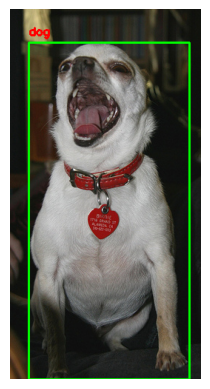

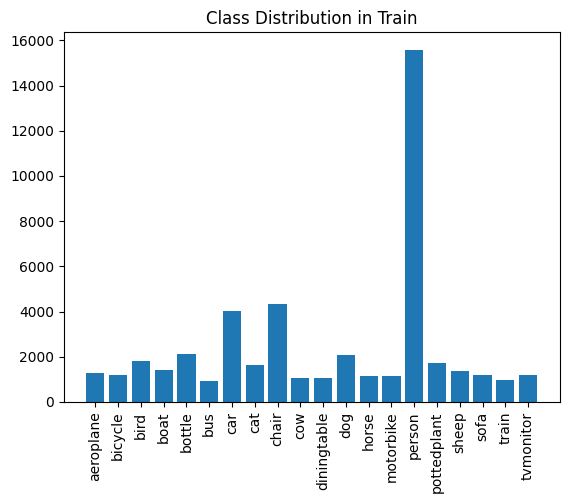

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

# Paths (adapted for data/custom_data)
custom_data_root = 'data/custom_data'
split = 'train'
images_dir = os.path.join(custom_data_root, 'images', split)
labels_dir = os.path.join(custom_data_root, 'labels', split)
custom_txt = os.path.join(custom_data_root, f'custom_{split}.txt')

classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
           'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

# Read list of IDs from custom_train.txt
with open(custom_txt, 'r') as f:
    all_ids = [line.strip() for line in f if line.strip()]

# Function to visualize image with bounding boxes
def visualize_image_with_boxes(img_path, label_path, classes):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert for matplotlib
    h, w = img.shape[:2]
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
        for line in lines:
            cls_id, x_center, y_center, width, height = map(float, line.strip().split())
            cls_name = classes[int(cls_id)]
            
            # Convert to absolute coordinates
            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)
            
            # Draw box and label
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, cls_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Select random image
random_id = random.choice(all_ids)
img_path = os.path.join(images_dir, f'{random_id}.jpg')
label_path = os.path.join(labels_dir, f'{random_id}.txt')

print(f"Visualizing {img_path}")
visualize_image_with_boxes(img_path, label_path, classes)

# Statistics: class distribution in train
class_counts = np.zeros(len(classes))
for label_file in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, label_file)
    with open(label_path, 'r') as f:
        for line in f:
            cls_id = int(line.split()[0])
            class_counts[cls_id] += 1

plt.bar(classes, class_counts)
plt.xticks(rotation=90)
plt.title('Class Distribution in Train')
plt.show()